# Mapping results Nath & Thingbaijam (2012)

This was originally written arond OpenQuake 1.6 which required
`openquake.oq_output.hazard_map_converter` to convert XML outputs to CSV.
Newer versions of OpenQuake output CSV diretly but it is not yet clear if the format is the same.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import glob
import codecs
import warnings

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

from openquake.hazardlib import imt

from toolbox import logspace, stdval, annotate

In [3]:
map_imts = ['PGA','SA(0.2)','SA(1.0)']
map_tables = ['India_pga.csv','India_psa_pt2sec.csv','India_psa_1sec.csv']
model_path = '../Data/nath2012probabilistic'
map_table_list = [os.path.join(model_path, item) for item in map_tables]
map_table_df_list = [pd.read_csv(file_name) for file_name in map_table_list]

In [4]:
df_map = map_table_df_list[0][['lon', 'lat']]
map_csv = 'NT2012_Figure_7_Indian_subcontinent_lon_lat.csv'
print('sites_csv = %s' % map_csv)
df_map.to_csv(map_csv, header=False, index=False, float_format='%g')

sites_csv = NT2012_Figure_7_Indian_subcontinent_lon_lat.csv


In [5]:
poes_nom = np.array([0.1, 0.02])
T_nom = 50  # years
rate = -np.log(1 - poes_nom)/T_nom  # per year
T_inv = 1.  # year
poes_inv = 1 - np.exp(-rate*T_inv)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]

print('investigation_time = %s' % str(T_inv))
print('poes = %s' % ' '.join(['%.5g' % poe for poe in poes_inv]))
print(poe_labels)

investigation_time = 1.0
poes = 0.002105 0.00040397
['10% in 50 years', '2% in 50 years']


In [6]:
imts = [imt.from_string(item) for item in ['PGA', 'SA(0.2)', 'SA(1.0)']]
im_levels = logspace(0.004, 5, 6)

print('intensity_measure_types_and_levels = {%s}' 
      % ', '.join(['"%s": [%s]' % (str(im_type), ', '.join([str(iml) for iml in im_levels])) 
                   for im_type in imts]))

intensity_measure_types_and_levels = {"PGA": [0.0047, 0.0068, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47, 0.68, 1.0, 1.5, 2.2, 3.3, 4.7], "SA(0.2)": [0.0047, 0.0068, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47, 0.68, 1.0, 1.5, 2.2, 3.3, 4.7], "SA(1.0)": [0.0047, 0.0068, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47, 0.68, 1.0, 1.5, 2.2, 3.3, 4.7]}


In [7]:
# areal_only_no_fmd_uncertainty_map
n_gmpe_lt_rlzs = 3*3*2*2*3*2*3*3*2
print('n_gmpe_lt_rlzs = %d' % n_gmpe_lt_rlzs)
n_src_lt_rlzs = 2
print('n_src_lt_rlzs = %d' % n_src_lt_rlzs)
n_lt_rlzs = n_gmpe_lt_rlzs*n_src_lt_rlzs
print('n_lt_rlzs = %d' % n_lt_rlzs)
n_sites = len(df_map)
print('n_sites = %d' % n_sites)
n_imt_iml = len(imts)*len(im_levels)
print('n_imt_iml = %dx%d = %d' % (len(imts),len(im_levels),n_imt_iml))
n_curves = n_lt_rlzs*n_sites*n_imt_iml
print('n_curves = n_lt_rlzs*n_sites*n_imt_iml = %d*%d*%d = %d' %
     (n_lt_rlzs, n_sites, n_imt_iml, n_curves))
n_files = n_lt_rlzs*n_imt_iml
print('n_files = n_lt_rlzs*n_imt_iml = %d*%d = %d' %
     (n_lt_rlzs, n_imt_iml, n_files))

n_gmpe_lt_rlzs = 3888
n_src_lt_rlzs = 2
n_lt_rlzs = 7776
n_sites = 8102
n_imt_iml = 3x19 = 57
n_curves = n_lt_rlzs*n_sites*n_imt_iml = 7776*8102*57 = 3591065664
n_files = n_lt_rlzs*n_imt_iml = 7776*57 = 443232


## Post-Processing

In [74]:
map_csv = '../Jobs/map_collapsed_v1/out/hazard_map-mean_18441.csv'
df_calc = pd.read_csv(map_csv, header=1, index_col=['lon', 'lat'])
with open(map_csv) as file:
    hazard_type, inv_time = file.readline().split(',')
hazard_type = hazard_type.split()[1]
assert inv_time.split('=')[0].strip() == 'investigation_time'
T_inv = float(inv_time.split('=')[1])
print('hazard: ' + hazard_type)
print('investigation_time: %g year' % T_inv)

hazard: mean
investigation_time: 1 year


In [75]:
imts, poes = zip(*[item.split('-') for item in df_calc.columns])
imts = sorted(set(imts))
poes = np.array([float(item) for item in sorted(set(poes))])
print('IMTs: %s' % ', '.join(imts))
print('POEs: %s' % ', '.join(str(item) for item in poes))

T_nom = 50  # years
rate = -np.log(1 - poes)/T_inv
poes_nom = 1 - np.exp(-rate*T_nom)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]
print('POEs in %g years: %s' % (T_nom, ', '.join('%g%%' % (100*poe) for poe in poes_nom)))

limits = (df_calc[df_calc != 0].min().min(), df_calc.max().max())
limits = stdval(limits, 3)
print('IML limits: ' + ', '.join('%g g' % item for item in limits))

grid_step = np.mean(np.diff(sorted(list(set(df_calc.index.get_level_values('lat'))))))
print('Grid step: %g°' % grid_step)

IMTs: PGA, SA(0.2), SA(1.0)
POEs: 0.00040397, 0.002105
POEs in 50 years: 1.99999%, 10%
IML limits: 0.005 g, 2 g
Grid step: 0.2°


Saving: hazard_map-mean_18441.pdf


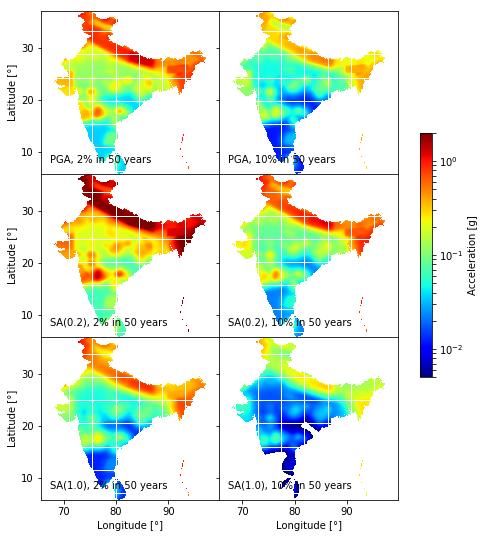

In [78]:
point_size = (grid_step/0.2)**2
fig, axes = plt.subplots(len(imts), len(poes), 
                         figsize=(4*len(poes),3*len(imts)), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for i, imt in enumerate(imts):
    for j, (poe, poe_nom) in enumerate(zip(poes, poes_nom)):
        fig.sca(axes[i, j])
        
        imt_poe_label = ('%s, %.3g%% in %g years' % 
                         (str(imt), 100*poe_nom, T_nom))
        annotate(imt_poe_label, 'lower left')
        
        im = plt.scatter(df_calc.index.get_level_values('lon'), 
                         df_calc.index.get_level_values('lat'), 
                         c=df_calc[imt + '-' + str(poe)].values, 
                         s=point_size, marker='s', edgecolor='none', cmap='jet', 
                         norm=LogNorm(limits[0], limits[1]))

axes[0, 0].set_aspect('equal')
axes[0, 0].autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Acceleration [g]')
        
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]
map_pdf = os.path.splitext(os.path.basename(map_csv))[0] + '.pdf'
print('Saving: ' + map_pdf)
fig.savefig(map_pdf, dpi=300, bbox_inches='tight')

Saving: map_published.pdf


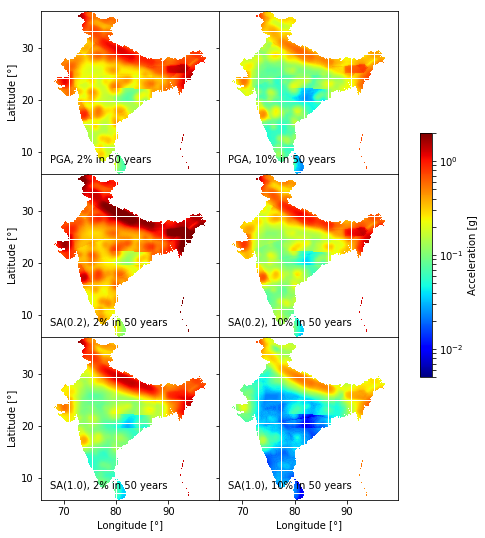

In [77]:
published_file_name = 'map_published.pdf'
model_path = '../Data/nath2012probabilistic'
map_files = ['India_pga.csv', 
             'India_psa_pt2sec.csv', 
             'India_psa_1sec.csv']

fig, axes = plt.subplots(len(imts), len(poes_inv), 
                         figsize=(4*len(poes_inv),3*len(imts)), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for i, (im_type, map_file) in enumerate(zip(imts, map_files)):
    for j, (poe_inv, poe_nom) in enumerate(zip(poes_inv, poes_nom)):
        fig.sca(axes[i, j])
        
        imt_poe_label = '%s, %.3g%% in %g years' % (str(im_type), 
                                                  100*poe_nom, T_nom)
        annotate(imt_poe_label, 'lower left')
        
        # figure out corresponding output file name        
        df_pub = pd.read_csv(os.path.join(model_path, map_file))
        col_name = 'prob' + '%.3g' % (100*poe_nom)
        col_name = col_name.replace('prob0.','prob_pt')
        
        grid_step = np.mean(np.diff(sorted(list(set(df_pub['lat'])))))
        point_size = (grid_step/0.2)**2
        im = plt.scatter(df_pub['lon'], df_pub['lat'], c=df_pub[col_name].values, 
                         s=point_size, marker='s', edgecolor='none', cmap='jet', 
                         norm=LogNorm(limits[0], limits[1]))

plt.gca().set_aspect('equal')
plt.autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Acceleration [g]')
        
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]
print('Saving: ' + published_file_name)
fig.savefig(published_file_name, dpi=300, bbox_inches='tight')